# Implementación de los modelos
## Proyecto de Aprendizaje Automático
#### Pablo Berástegui Magallón (202311460)
#### Ingeniería Matemática e Inteligencia Artificial
#### Universidad Pontificia Comillas

---
### Importación de librerías y de los datos preparados para ser analizados

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.utils import evaluation_metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import ElasticNet, LassoCV, RidgeCV, LinearRegression

In [32]:
df = pd.read_csv('../data/rendimiento_estudiantes_train_clean.csv')
df.drop(columns='Unnamed: 0', inplace=True)

---
## **Modelo i)** Todas las variables

Como hemos mostrado antes, muchas de las variables son categóricas. Para trabajar con ellas debemos codificarlas con *one_hot_encoding*

In [33]:
num_vars = df.select_dtypes(include=['number']).columns
# Variables categóricas
cat_vars = df.select_dtypes(include=['object', 'category']).columns
cat_idx = [list(df.columns).index(var) for var in cat_vars]

In [34]:
df = pd.get_dummies(df, cat_vars, drop_first=True)

In [35]:
X1 = df.drop(columns=['T3']).to_numpy()
y = df['T3'].to_numpy()

# Estandarizar los datos
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

---

### Los modelos más sencillos

#### a) La media ($\mu$)

Tomemos la media de nuestra variable objetivo del entrenamiento como predicción más simple. Esta métrica nos permitirá tener un punto de partida a partir del cual mejorar comparativamente.

In [37]:
y_mean = np.mean(y)

evaluation_metrics(y_test, np.full_like(y_test, y_mean))

{'R2': -0.01667054153427583,
 'RMSE': 4.115110173072763,
 'MAE': 3.0059880239520957}

#### b) `T2` como predictor

Basaremos nuestra predicción en T3 = T2. Veamos el rendimiento de esto

In [38]:
evaluation_metrics(df['T3'], df['T2'])

{'R2': 0.8326031808016412,
 'RMSE': 1.6327486835006342,
 'MAE': 0.8479041916167664}

### Regresión lineal (sin regularización)

In [39]:
linreg = LinearRegression(copy_X=True)
linreg.fit(X_train, y_train)

LinearRegression()

In [40]:
y_pred = linreg.predict(X_test)
evaluation_metrics(y_test, y_pred)

{'R2': 0.8462534600968518,
 'RMSE': 1.6002727957131344,
 'MAE': 0.9845037833116681}

### Regularización Lasso (L1)

In [41]:
lasso = LassoCV(eps=1e-4, n_alphas=50)
lasso.fit(X_train, y_train)

LassoCV(eps=0.0001, n_alphas=50)

In [42]:
print('Alpha óptimo: ', lasso.alpha_)

coefs = np.array(lasso.coef_)
nonezero_idx = coefs.nonzero()[0]

Alpha óptimo:  0.10240764944986076


In [43]:
y_pred = lasso.predict(X_test)

evaluation_metrics(y_test, y_pred)

nonzero_predictors = df.drop(columns=['T3']).columns[nonezero_idx]
print(nonzero_predictors.tolist())
print(coefs[nonezero_idx])

['suspensos', 'faltas', 'T1', 'T2', 'Mtrab_otros', 'pareja_si', 'asignatura_M']
[-0.055569    0.06950821  0.38508328  3.14349581 -0.00415738 -0.00712068
 -0.18931451]


### Regularización Ridge (L2)

In [44]:
ridge = RidgeCV(alphas=np.logspace(-3, 20, 30))
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-03, 6.21016942e-03, 3.85662042e-02, 2.39502662e-01,
       1.48735211e+00, 9.23670857e+00, 5.73615251e+01, 3.56224789e+02,
       2.21221629e+03, 1.37382380e+04, 8.53167852e+04, 5.29831691e+05,
       3.29034456e+06, 2.04335972e+07, 1.26896100e+08, 7.88046282e+08,
       4.89390092e+09, 3.03919538e+10, 1.88739182e+11, 1.17210230e+12,
       7.27895384e+12, 4.52035366e+13, 2.80721620e+14, 1.74332882e+15,
       1.08263673e+16, 6.72335754e+16, 4.17531894e+17, 2.59294380e+18,
       1.61026203e+19, 1.00000000e+20]))

In [45]:
print('Alpha óptimo: ', ridge.alpha_)

Alpha óptimo:  9.236708571873866


In [46]:
y_pred = ridge.predict(X_test)

evaluation_metrics(y_test, y_pred)

{'R2': 0.8447462629931975,
 'RMSE': 1.6080975058339435,
 'MAE': 0.9899002038647684}

### Regularización Elastic Net

Tenemos que hallar los parámetros óptimos para nuestro modelo Elastic Net (L1 + L2), es decir, aquellos parámetros que dan mejores resultados de test. Para ello, el método a utilizar es **validación cruzada**.

In [47]:
n_alphas = 6
alphas = np.logspace(-4, 1, n_alphas)
print('Alphas: ', [round(a, 4) for a in alphas])

n_ratios = 4
ratios = np.linspace(0, 1, n_ratios)
print('Ratios: ', [round(r, 2) for r in ratios])

scores = np.zeros((len(alphas), len(ratios)))

Alphas:  [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
Ratios:  [0.0, 0.33, 0.67, 1.0]


In [48]:
for i in range(n_alphas):
    alpha = alphas[i]
    for j in range(n_ratios):
        l1_ratio = ratios[j]
        elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=5000)
        elastic.fit(X_train, y_train)
        cv_results = cross_validate(elastic, X_train, y_train, cv=20, scoring='neg_mean_squared_error')
        rmse = np.sqrt(-cv_results['test_score'])
        scores[i, j] = np.mean(rmse)

c:\Users\teach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.693e+02, tolerance: 1.051e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\teach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.388e+02, tolerance: 1.012e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

In [49]:
opt_score = scores.min()
opt_idx = np.argmin(scores)

alpha_opt_idx = opt_idx // n_ratios
ratio_opt_idx = opt_idx % n_ratios

opt_alpha = alphas[alpha_opt_idx]
opt_ratio = ratios[ratio_opt_idx]

print('Alpha óptimo: ', opt_alpha)
print('L1-ratio óptimo: ', opt_ratio)

Alpha óptimo:  0.1
L1-ratio óptimo:  1.0


Volvemos a entrenar el modelo con los parámetros óptimos hallados, anticipando el resultado, porque $L1ratio = 1$ significa que se está empleando Lasso al completo.

In [50]:
elastic = ElasticNet(alpha=opt_alpha, l1_ratio=opt_ratio, max_iter=5000)
elastic.fit(X_train, y_train)

y_pred = elastic.predict(X_test)
evaluation_metrics(y_test, y_pred)

{'R2': 0.847384900345993,
 'RMSE': 1.5943736174348495,
 'MAE': 0.9270903891573892}

### Random Forest

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

Inicializamos nuestro `Random Forest` con unos parámetros elegidos arbitrariamente

In [52]:
rf = RandomForestRegressor(n_estimators=100,
                           max_depth=None,
                           min_samples_split=2,   
                           min_samples_leaf=1,
                           max_features=None,   # o 'sqrt'
                           random_state=42)

Primero vamos a hacer un 5-fold CV rápido para ver cómo se comporta nuestro set de entrenamiento para los parámetros dados.

In [53]:
scores = cross_val_score(
    rf, X_train, y_train,
    scoring='neg_mean_squared_error',
    cv=5
)
rmse_scores = np.sqrt(-scores)
print("RMSE en CV:", rmse_scores.mean())

RMSE en CV: 1.5643786560294974


Ahora vamos a ver si se pueden afinar los resultados utilizando `grid search` para hacer *fine tuning* de los hiperparámetros `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`.

In [54]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [None, 'sqrt', 'log2']
}

In [55]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,   # 5 folds
    n_jobs=-1,  # usa todos los cores disponibles
    verbose=1
)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features=None,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [56]:
best_rf = grid_search.best_estimator_
print("Mejores parámetros:", grid_search.best_params_)

y_pred = best_rf.predict(X_test)
evaluation_metrics(y_test, y_pred)

Mejores parámetros: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


{'R2': 0.8889425340142525,
 'RMSE': 1.3600824196953187,
 'MAE': 0.8723444572350039}

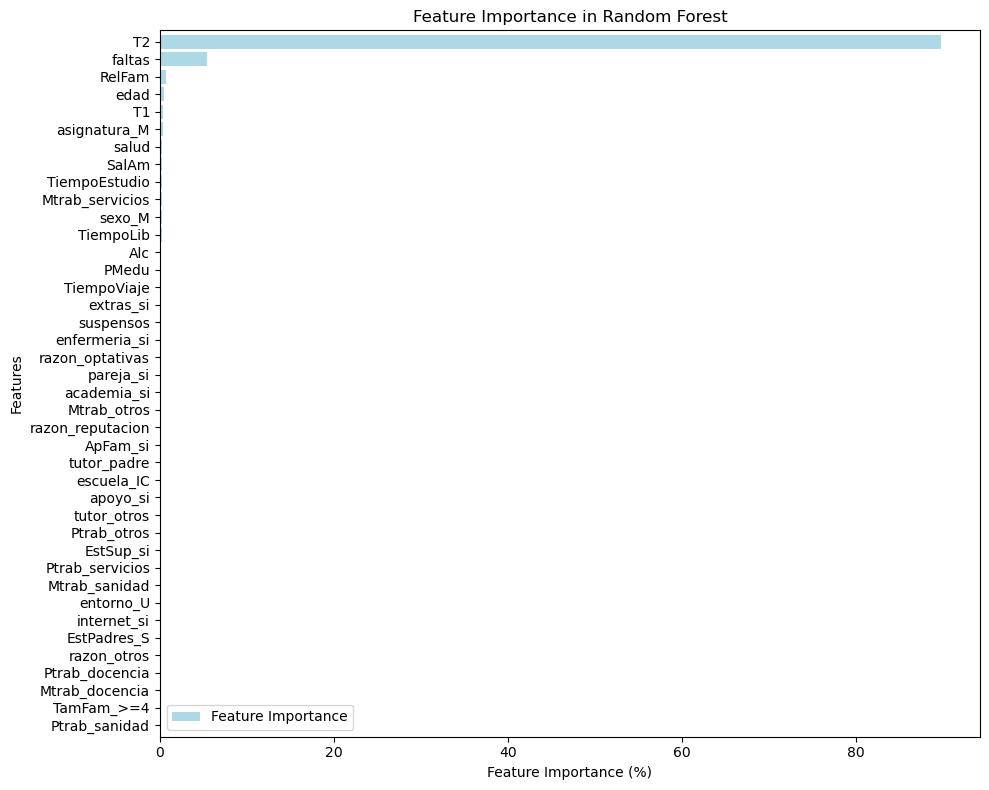

                 Feature Importance
T2                        89.752365
faltas                     5.425187
RelFam                     0.675634
edad                       0.474855
T1                         0.411868
asignatura_M               0.335777
salud                      0.305831
SalAm                      0.266800
TiempoEstudio              0.220393
Mtrab_servicios            0.209027


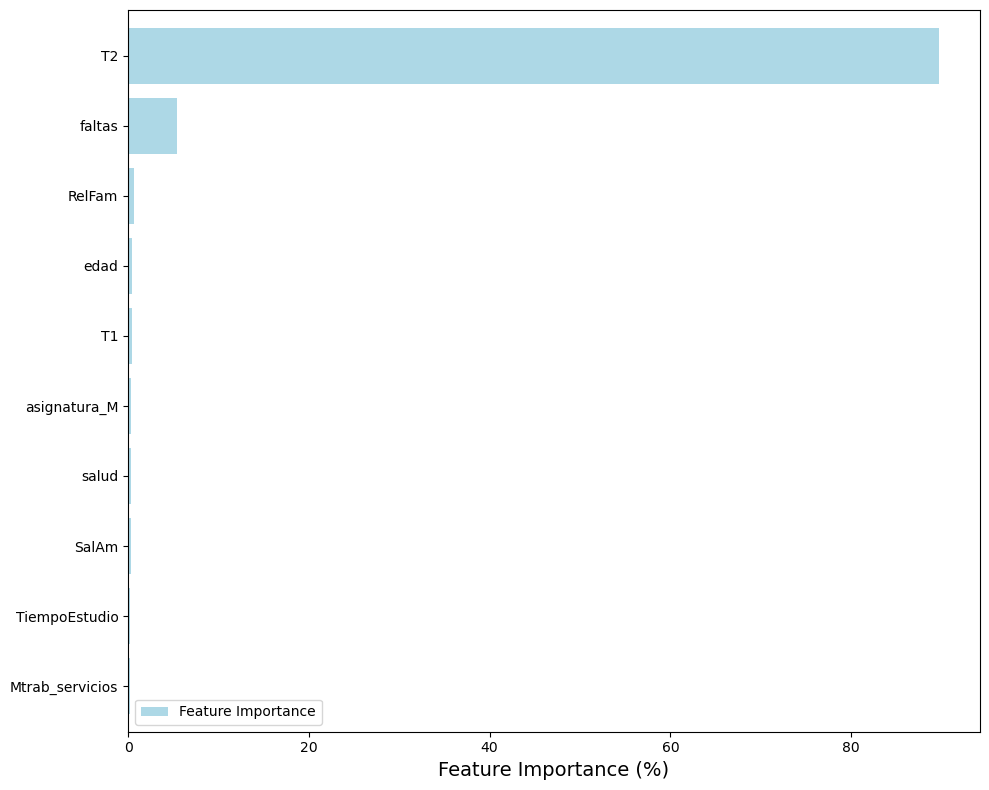

In [57]:
rf_featureImportance= pd.DataFrame({'Feature Importance':best_rf.feature_importances_*100}, index= df.drop(columns='T3').columns)
rf_featureImportance.sort_values('Feature Importance', ascending=True).plot(
    kind='barh', 
    color='lightblue',
    figsize=(10, 8),
    width=0.8  # Reduce the bar width to add more spacing
)
plt.xlabel('Feature Importance (%)')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

# Mostrar las 10 características más importantes
top_10_features = rf_featureImportance.sort_values('Feature Importance', ascending=False).head(10)
print(top_10_features)

# Opcional: graficar solo las 10 características más importantes
top_10_features.sort_values('Feature Importance', ascending=True).plot(
    kind='barh',
    color='lightblue',
    figsize=(10, 8),
    width=0.8  # Reduce the bar width to add more spacing
)

plt.xlabel('Feature Importance (%)', fontsize=14)
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

### Predicciones del test

Como Random Forest tiene los mejores resultados para el modelo i), lo emplearemos para predecir la variable objetivo en el test.

In [66]:
df_test = pd.read_csv('../data/rendimiento_estudiantes_test_vacio_clean.csv')

df_test = pd.get_dummies(df_test, cat_vars, drop_first=True)
df_test.drop(columns='Unnamed: 0', inplace=True)
df_test

,edad,PMedu,TiempoViaje,TiempoEstudio,suspensos,RelFam,TiempoLib,SalAm,Alc,salud,...,tutor_padre,apoyo_si,ApFam_si,academia_si,extras_si,enfermeria_si,EstSup_si,internet_si,pareja_si,asignatura_M
0,17,1.0,1,2,0,5,3,3,1,3,...,False,False,False,False,True,True,True,True,False,True
1,16,4.0,1,1,0,3,5,5,3,4,...,False,False,False,False,True,True,True,True,False,False
2,17,2.5,1,2,0,5,3,3,2,3,...,True,False,True,False,False,False,True,True,False,False
3,15,2.5,2,1,0,3,5,1,1,5,...,True,False,True,False,True,True,True,False,False,False
4,15,3.5,1,2,0,4,5,2,1,5,...,False,False,True,False,True,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,16,2.0,2,2,1,3,3,3,1,3,...,False,False,True,False,True,False,True,True,True,True
205,15,1.5,1,2,0,4,3,2,1,5,...,False,False,True,False,False,False,True,True,False,False
206,17,2.5,1,1,1,4,4,4,3,3,...,False,False,False,False,False,True,True,True,False,True
207,15,3.0,1,4,0,4,3,3,1,4,...,True,True,False,False,False,True,True,False,False,False


In [67]:
scaler = StandardScaler()
X_test_def = scaler.fit_transform(df_test.drop(columns=['T3']))

predicciones_modelo_i = best_rf.predict(X_test_def)
print(predicciones_modelo_i)

[ 4.01754895 14.35519684 11.01679392 11.01165796 14.479814   14.45997155
  8.18977532  9.86766896 16.30616757  9.86635057 13.19036704 10.92207053
  6.16639446 13.06552586  9.48667789  7.42733295 13.08285619 16.1568998
 10.01101347 11.0459056  13.08430084 10.87367188 12.03375311 12.65592821
 10.81066773 13.15426107  8.57481903 11.03874738  9.98352642 11.90828347
 10.06335269 13.04485768 13.05665168  7.12550923  0.75014984 10.98256376
  9.80102761  9.58328974 12.07407244  9.35593666 13.11500961  6.17711302
 13.09353886 10.02416378 11.11039952 13.07155715 12.98441009 10.19027825
  0.09325998 17.79865634  9.50422789 17.73505113 10.05970819 11.00377334
 13.11161115  6.08318366  9.92490171 14.28701247 14.37860748  9.48667542
  6.97661463 14.68985016  7.25311193  3.01381656 14.37230037 13.06954302
 13.12000075  9.59689733  9.7121703  12.97828216  9.55952874 18.95165679
 13.11616837 13.22329728  7.35888239  7.37303565  5.92685925 10.47999433
 14.40928809  8.65885114 11.01623063  7.60637354 10.

### XGBoosting

In [68]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, uniform

In [69]:
booster = XGBRegressor(
        objective     = "reg:squarederror",
        tree_method   = "hist",          # usa "gpu_hist" si dispones de GPU
        random_state  = 42,
        n_jobs        = -1,
        eval_metric   = "rmse"
)

In [70]:
param_dist = {
    "n_estimators"        : randint(200, 800),      # nº árboles boosting
    "learning_rate"       : uniform(0.01, 0.19),    # 0.01 – 0.20
    "max_depth"           : randint(3, 9),          # profundidad árbol
    "min_child_weight"    : randint(1, 8),
    "subsample"           : uniform(0.6, 0.4),      # 0.6 – 1.0
    "colsample_bytree"    : uniform(0.6, 0.4),      # 0.6 – 1.0
    "gamma"               : uniform(0, 0.5),        # regularización de nodos
    "reg_lambda"          : uniform(0.0, 1.0)       # L2
}

In [71]:
fit_kwargs = {
    "eval_set"                : [(X_test, y_test)],   # se usa como validación
    "verbose"                 : False,
}

random_search = RandomizedSearchCV(
        estimator      = booster,
        param_distributions = param_dist,
        n_iter         = 40,             # nº de combinaciones a explorar
        scoring        = "neg_root_mean_squared_error",
        cv             = 5,              # 5 folds
        random_state   = 42,
        n_jobs         = -1,
        verbose        = 1,
        refit          = True            # re‑entrena con la mejor combinación
)

random_search.fit(X_train, y_train, **fit_kwargs)

print("Mejores hiperparámetros:", random_search.best_params_)
print("RMSE CV (negativo):", random_search.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Mejores hiperparámetros: {'colsample_bytree': 0.786705157299192, 'gamma': 0.4299702033681603, 'learning_rate': 0.13925843233167814, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 473, 'reg_lambda': 0.9488855372533332, 'subsample': 0.9862528132298237}
RMSE CV (negativo): -1.4702719449996948


In [72]:
best_xgb = random_search.best_estimator_
y_pred   = best_xgb.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE : {mae:.3f}")
print(f"Test R²  : {r2:.3f}")


Test RMSE: 1.400
Test MAE : 0.951
Test R²  : 0.882


---
## **Modelo ii)** Excluimos `T1` y `T2`.

Predecir `T3` en base a las variables ahora no parece una tarea tan sencilla, dado que ya no contamos con `T1` y `T2`, que eran las que mostraban mayor correlación con la variable objetivo y, a nivel intuitivo, resultaba lógico predecir la nota final a partir de la del primer y segundo trimestre.

In [73]:
X2 = df.drop(columns=['T1', 'T2', 'T3']).to_numpy()
y = df['T3'].to_numpy()

In [74]:
# Estandarizar los datos
scaler = StandardScaler()
X2 = scaler.fit_transform(X2)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

### Regresión lineal (sin regularización)

In [76]:
linreg = LinearRegression(copy_X=True)
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)
evaluation_metrics(y_test, y_pred)

{'R2': 0.2678650150903724,
 'RMSE': 3.4921020533555716,
 'MAE': 2.519320885507693}

### Regularización Lasso (L1)

In [77]:
lasso = LassoCV(eps=1e-4, n_alphas=20)
lasso.fit(X_train, y_train)

LassoCV(eps=0.0001, n_alphas=20)

In [78]:
print('Alpha óptimo: ', lasso.alpha_)
y_pred = lasso.predict(X_test)
evaluation_metrics(y_test, y_pred)

Alpha óptimo:  0.07273346712844135


{'R2': 0.2991210635817586,
 'RMSE': 3.416747231519712,
 'MAE': 2.4470070420901355}

### Regularización Ridge (L2)

In [79]:
ridge = RidgeCV(alphas=np.logspace(-3, 20, 30))
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-03, 6.21016942e-03, 3.85662042e-02, 2.39502662e-01,
       1.48735211e+00, 9.23670857e+00, 5.73615251e+01, 3.56224789e+02,
       2.21221629e+03, 1.37382380e+04, 8.53167852e+04, 5.29831691e+05,
       3.29034456e+06, 2.04335972e+07, 1.26896100e+08, 7.88046282e+08,
       4.89390092e+09, 3.03919538e+10, 1.88739182e+11, 1.17210230e+12,
       7.27895384e+12, 4.52035366e+13, 2.80721620e+14, 1.74332882e+15,
       1.08263673e+16, 6.72335754e+16, 4.17531894e+17, 2.59294380e+18,
       1.61026203e+19, 1.00000000e+20]))

In [80]:
print('Alpha óptimo: ', ridge.alpha_)

y_pred = ridge.predict(X_test)
evaluation_metrics(y_test, y_pred)

Alpha óptimo:  57.361525104486816


{'R2': 0.2798572404815287, 'RMSE': 3.463384000378185, 'MAE': 2.489896211098704}

### Regularización Elastic Net

Tenemos que hallar los parámetros óptimos para nuestro modelo Elastic Net (L1 + L2), es decir, aquellos parámetros que dan mejores resultados de test. Para ello, el método a utilizar es **validación cruzada**.

In [81]:
scores = np.zeros((len(alphas), len(ratios)))

In [82]:
for i in range(n_alphas):
    alpha = alphas[i]
    for j in range(n_ratios):
        l1_ratio = ratios[j]
        elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=5000)
        elastic.fit(X_train, y_train)
        cv_results = cross_validate(elastic, X_train, y_train, cv=20, scoring='neg_mean_squared_error')
        rmse = np.sqrt(-cv_results['test_score'])
        scores[i, j] = np.mean(rmse)

c:\Users\teach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.750e+03, tolerance: 1.051e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\teach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.612e+03, tolerance: 1.012e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

In [83]:
opt_score = scores.min()
opt_idx = np.argmin(scores)

alpha_opt_idx = opt_idx // n_ratios
ratio_opt_idx = opt_idx % n_ratios

opt_alpha = alphas[alpha_opt_idx]
opt_ratio = ratios[ratio_opt_idx]

print('Alpha óptimo: ', opt_alpha)
print('L1-ratio óptimo: ', opt_ratio)

Alpha óptimo:  0.1
L1-ratio óptimo:  0.0


Volvemos a entrenar el modelo con los parámetros óptimos hallados, anticipando el resultado, porque $L1ratio = 1$ significa que se está empleando Lasso al completo.

In [84]:
elastic = ElasticNet(alpha=opt_alpha, l1_ratio=opt_ratio, max_iter=5000)
elastic.fit(X_train, y_train)

y_pred = elastic.predict(X_test)
evaluation_metrics(y_test, y_pred)

c:\Users\teach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.865e+03, tolerance: 1.051e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


{'R2': 0.2807356758090721,
 'RMSE': 3.4612710254453294,
 'MAE': 2.4876865251975073}

### Random Forest

Inicializamos nuestro `Random Forest` con unos parámetros elegidos arbitrariamente

In [85]:
rf = RandomForestRegressor(n_estimators=100,
                           max_depth=None,
                           min_samples_split=2,   
                           min_samples_leaf=1,
                           max_features=None,   # o 'sqrt'
                           random_state=42)

Primero vamos a hacer un 5-fold CV rápido para ver cómo se comporta nuestro set de entrenamiento para los parámetros dados.

In [86]:
scores = cross_val_score(
    rf, X_train, y_train,
    scoring='neg_mean_squared_error',
    cv=5
)
rmse_scores = np.sqrt(-scores)
print("RMSE en CV:", rmse_scores.mean())

RMSE en CV: 3.384281751944125


Ahora vamos a ver si se pueden afinar los resultados utilizando `grid search` para hacer *fine tuning* de los hiperparámetros `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`.

In [87]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,   # 5 folds
    n_jobs=-1,  # usa todos los cores disponibles
    verbose=1
)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features=None,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [88]:
best_rf = grid_search.best_estimator_
print("Mejores parámetros:", grid_search.best_params_)

y_pred = best_rf.predict(X_test)
evaluation_metrics(y_test, y_pred)

Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


{'R2': 0.3699494928228837, 'RMSE': 3.239507798793378, 'MAE': 2.378323353293411}

               Feature Importance
faltas                   8.155085
suspensos                7.620429
PMedu                    6.043458
SalAm                    5.487529
edad                     4.483521
asignatura_M             4.269271
TiempoLib                4.252437
salud                    4.193693
TiempoEstudio            3.965759
Alc                      3.947558


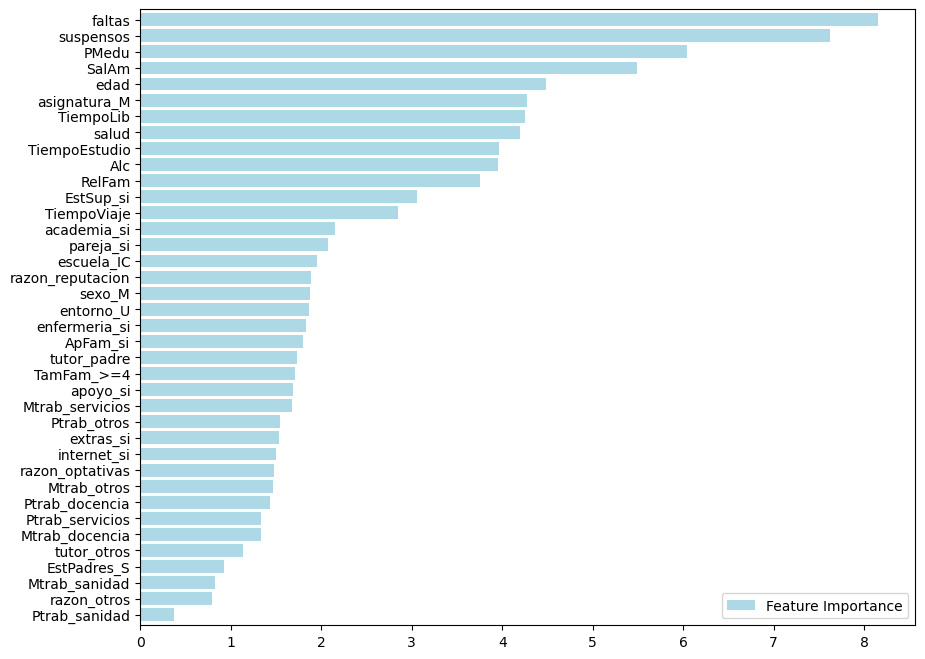

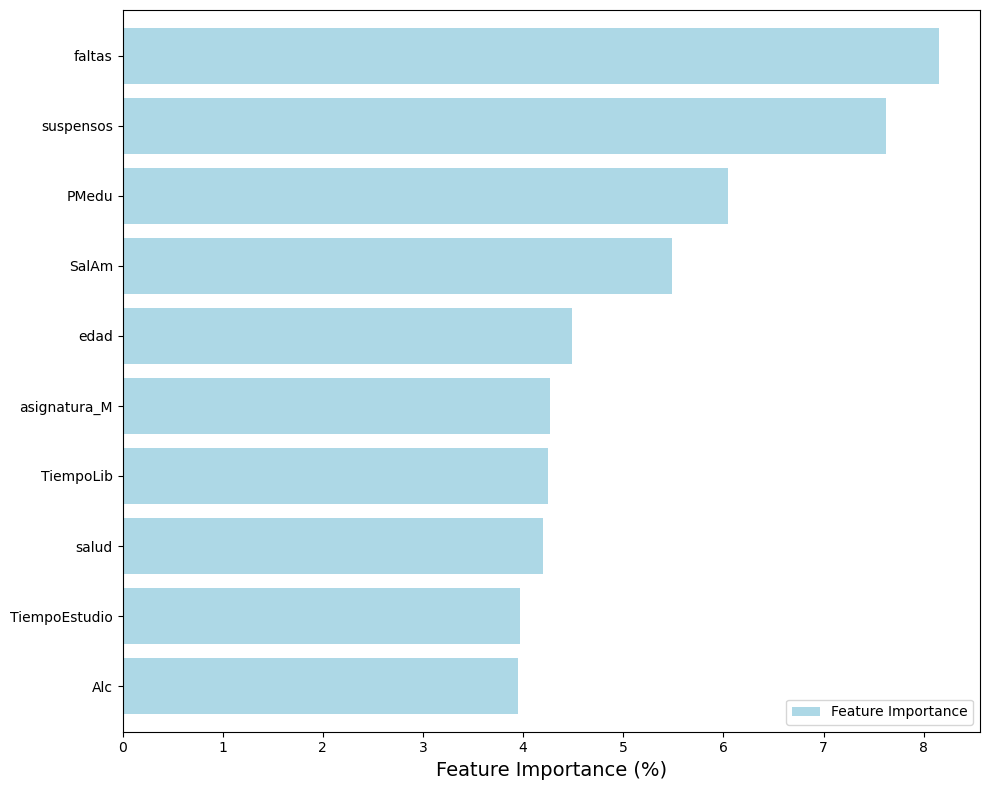

In [89]:
rf_featureImportance= pd.DataFrame({'Feature Importance':best_rf.feature_importances_*100}, index= df.drop(columns=['T1', 'T2', 'T3']).columns)
rf_featureImportance.sort_values('Feature Importance', ascending=True).plot(
    kind='barh', 
    color='lightblue',
    figsize=(10, 8),
    width=0.8  # Reduce the bar width to add more spacing
)
# Mostrar las 10 características más importantes
top_10_features = rf_featureImportance.sort_values('Feature Importance', ascending=False).head(10)
print(top_10_features)

# Opcional: graficar solo las 10 características más importantes
top_10_features.sort_values('Feature Importance', ascending=True).plot(
    kind='barh',
    color='lightblue',
    figsize=(10, 8),
    width=0.8  # Reduce the bar width to add more spacing
)
plt.xlabel('Feature Importance (%)', fontsize=14)
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

### XGBoosting

In [90]:
booster = XGBRegressor(
        objective     = "reg:squarederror",
        tree_method   = "hist",          # usa "gpu_hist" si dispones de GPU
        random_state  = 42,
        n_jobs        = -1,
        eval_metric   = "rmse"
)

In [91]:
param_dist = {
    "n_estimators"        : randint(200, 800),      # nº árboles boosting
    "learning_rate"       : uniform(0.01, 0.19),    # 0.01 – 0.20
    "max_depth"           : randint(3, 9),          # profundidad árbol
    "min_child_weight"    : randint(1, 8),
    "subsample"           : uniform(0.6, 0.4),      # 0.6 – 1.0
    "colsample_bytree"    : uniform(0.6, 0.4),      # 0.6 – 1.0
    "gamma"               : uniform(0, 0.5),        # regularización de nodos
    "reg_lambda"          : uniform(0.0, 1.0)       # L2
}

In [92]:
fit_kwargs = {
    "eval_set"                : [(X_test, y_test)],   # se usa como validación
    "verbose"                 : False,
}

random_search = RandomizedSearchCV(
        estimator      = booster,
        param_distributions = param_dist,
        n_iter         = 40,             # nº de combinaciones a explorar
        scoring        = "neg_root_mean_squared_error",
        cv             = 5,              # 5 folds
        random_state   = 42,
        n_jobs         = -1,
        verbose        = 1,
        refit          = True            # re‑entrena con la mejor combinación
)

random_search.fit(X_train, y_train, **fit_kwargs)

print("Mejores hiperparámetros:", random_search.best_params_)
print("RMSE CV (negativo):", random_search.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Mejores hiperparámetros: {'colsample_bytree': 0.9978202043189364, 'gamma': 0.23497225699547147, 'learning_rate': 0.06311646494138413, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 236, 'reg_lambda': 0.9283185625877254, 'subsample': 0.7712736593269257}
RMSE CV (negativo): -3.337650442123413


In [93]:
best_xgb = random_search.best_estimator_
y_pred   = best_xgb.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE : {mae:.3f}")
print(f"Test R²  : {r2:.3f}")


Test RMSE: 3.049
Test MAE : 2.348
Test R²  : 0.442


### Predicciones del test

Como Random Forest tiene los mejores resultados para el modelo i), lo emplearemos para predecir la variable objetivo en el test.

In [96]:
X_test_def = scaler.fit_transform(df_test.drop(columns=['T1', 'T2', 'T3']))

predicciones_modelo_ii = best_xgb.predict(X_test_def)
print(predicciones_modelo_ii)

[ 7.4224606  11.4013605   9.99977    10.462754    9.341855    9.599951
  4.314469   10.330444    9.450392   -0.7292024   9.6469      8.071022
  8.640801    5.8672404   9.146908    8.502523    9.450738    6.4789495
  8.767543    9.307554    9.664841    4.568673    9.666099    8.744036
  9.915982   10.381311   10.165125    9.322955    7.311887    7.9748797
 10.609112   10.398437   10.973681    8.828306    7.4429827   8.187998
  8.889879   10.261477    6.9446163   8.874994   10.280685    8.543759
 11.102781    9.432286    9.597819    8.485031   10.900046   10.723849
  0.97129476 11.274867   10.374912   10.678266    9.4022      9.206512
 10.17566     8.19231     8.304862    8.936153   10.69104    10.838593
 11.642439    9.606995   10.434421    1.5288852  10.534384    8.762607
  8.714519   10.977682   10.2037735  11.059924    9.369324    9.617531
 10.427765    9.886976   10.031674    9.357985    9.820678   10.984144
  8.850514    6.8610883   9.7439575   8.684561    9.767406   10.806244
 11.

---
## Parte creativa: PCA y Clustering

Primero importamos las librerías que no habían hecho falta hasta ahora.

In [97]:
from sklearn.compose        import ColumnTransformer
from sklearn.preprocessing   import OneHotEncoder, StandardScaler
from sklearn.pipeline        import Pipeline
from sklearn.decomposition   import PCA
from sklearn.cluster         import KMeans
from sklearn.metrics         import silhouette_score
from sklearn.model_selection import train_test_split
import seaborn as sns

En este caso, para entrenar al PCA, utilizaremos la matriz sin `T1`, `T2` ni `T3`

In [98]:
df = pd.read_csv("../data/rendimiento_estudiantes_train_clean.csv")
X = df.drop(columns=["T1", "T2", "T3"]).reset_index(drop=True)
y = df["T3"]

In [99]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=None)

cat_vars = X.select_dtypes(include=["object", "category"]).columns
num_vars = X.select_dtypes(include=["number"]).columns

Vamos a optar por un sistema de preprocesamiento y entrenamiento un poco más sencillo, que es utilizando un pipeline

In [100]:
preproc = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(),   num_vars),
        ("cat", OneHotEncoder(drop="first"), cat_vars),
    ],
    remainder="drop"
)

In [101]:
pipe_pca = Pipeline(steps=[
    ("prep" , preproc),
    ("pca"  , PCA(n_components=None, random_state=42))
])

pipe_pca.fit(X_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Unnamed: 0', 'edad', 'PMedu', 'TiempoViaje', 'TiempoEstudio',
       'suspensos', 'RelFam', 'TiempoLib', 'SalAm', 'Alc', 'salud', 'faltas'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['escuela', 'sexo', 'entorno', 'TamFam', 'EstPadres', 'Mtrab', 'Ptrab',
       'razon', 'tutor', 'apoyo', 'ApFam', 'academia', 'extras', 'enfermeria',
       'EstSup', 'internet', 'pareja', 'asignatura'],
      dtype='object'))])),
                ('pca', PCA(random_state=42))])

Analizar varianza acumulada

39
Varianza explicada por cada componente:  [0.12368742 0.2161417  0.29162821 0.35997393 0.42433837 0.48399176
 0.54219652 0.59573157 0.64104134 0.6838715  0.72112616 0.7573326
 0.78232152 0.80036659 0.81791394 0.83431259 0.84922208 0.86365522
 0.87714342 0.88926653 0.90071037 0.91097424 0.92040859 0.92947321
 0.93791764 0.94603278 0.95400209 0.96071218 0.96628929 0.97152713
 0.97658799 0.98132719 0.98567332 0.98955573 0.99266435 0.99537167
 0.99803912 0.99942863 1.        ]


C:\Users\teach\AppData\Local\Temp\ipykernel_40028\2959513333.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


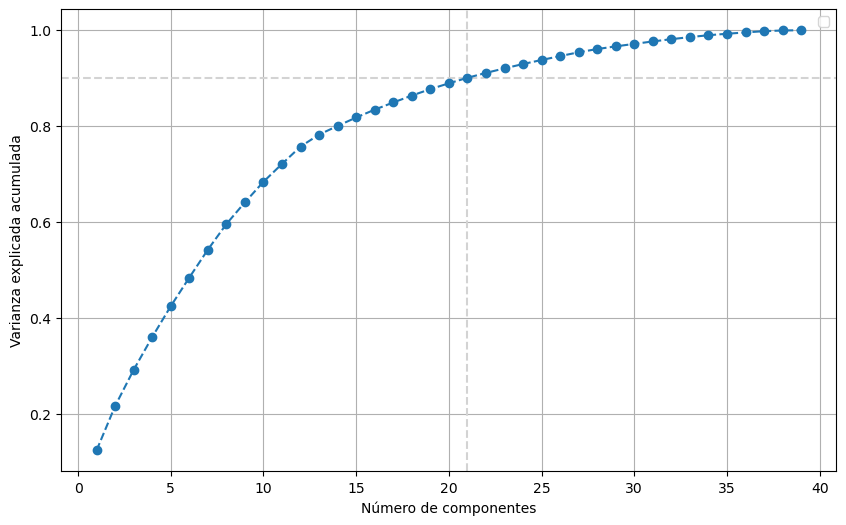

In [102]:
explained_var = np.cumsum(pipe_pca["pca"].explained_variance_ratio_)
print(len(explained_var))
print("Varianza explicada por cada componente: ", explained_var)
plt.figure(figsize=(10, 6))
plt.axvline(x=21, color='lightgrey', linestyle='--')
plt.axhline(y=explained_var[20], color='lightgrey', linestyle='--')
plt.plot(range(1, len(explained_var) + 1), explained_var, marker="o", linestyle="--")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.legend()
plt.grid()
plt.show()

In [103]:
n_comps = np.argmax(explained_var >= 0.90) + 1      # primera ≥90 %
pca_k = PCA(n_components=n_comps, random_state=42)

pipe_k = Pipeline(steps=[
    ("prep", preproc),
    ("pca" , pca_k)
])

Ahora transformamos, sólo con los componentes seleccionados, el conjunto de entrenamiento y también el de test

In [104]:
Z_train = pipe_k.fit_transform(X_train)   # → matriz n_samples × n_comps
Z_test  = pipe_k.transform(X_test)

In [105]:
Z_train.shape

(668, 21)

c:\Users\teach\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\teach\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\teach\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\teach\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

Número óptimo de clusters:  2


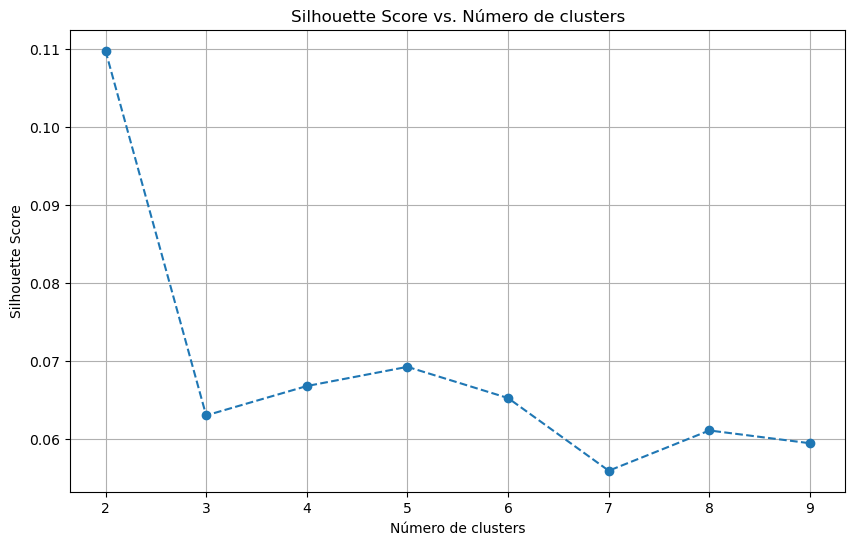

In [106]:
k_range  = range(2, 10)
silh     = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(Z_train)
    silh.append(silhouette_score(Z_train, labels))

k_opt = k_range[int(np.argmax(silh))]
print("Número óptimo de clusters: ", k_opt)
plt.figure(figsize=(10, 6))
plt.plot(k_range, silh, marker="o", linestyle="--")
plt.title("Silhouette Score vs. Número de clusters")
plt.xlabel("Número de clusters")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

In [107]:
best_km   = KMeans(n_clusters=k_opt, random_state=42)
train_lbl = best_km.fit_predict(Z_train)
test_lbl  = best_km.predict(Z_test)

c:\Users\teach\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


### Visualización de los clusters resultantes en las componentes principales

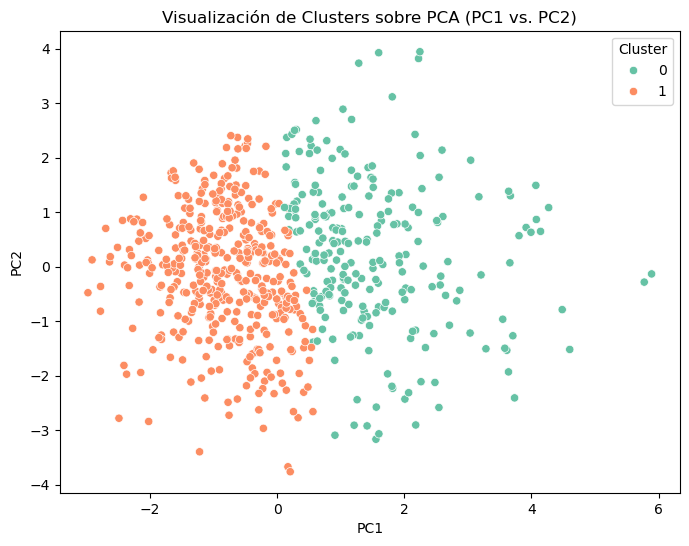

In [108]:
pc_df = pd.DataFrame(Z_train[:, :2], columns=["PC1", "PC2"])
pc_df["cluster_id"] = train_lbl
pc_df["T3"] = y_train.values    # opcional, colorear por T3
pc_df["edad"] = X_train["edad"].values

# este cluster aporta poca información
# 1. Scatter plot simple por cluster_id
plt.figure(figsize=(8,6))
sns.scatterplot(data=pc_df, x="PC1", y="PC2", hue="cluster_id", palette="Set2")
plt.title("Visualización de Clusters sobre PCA (PC1 vs. PC2)")
plt.legend(title="Cluster")
plt.show()

El cluster nos da muy poca información, por lo que se obvia en el informe.

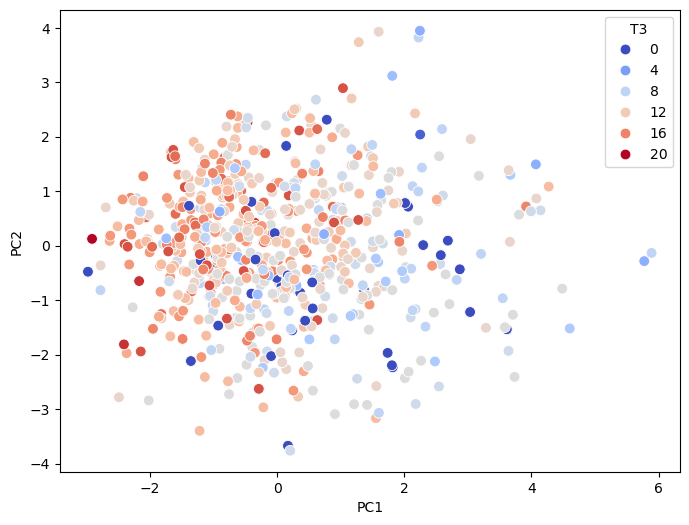

In [109]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=pc_df, x="PC1", y="PC2", hue="T3", palette="coolwarm", s=60)
# plt.title("Distribución de T3 sobre PC1 vs. PC2")
plt.show()

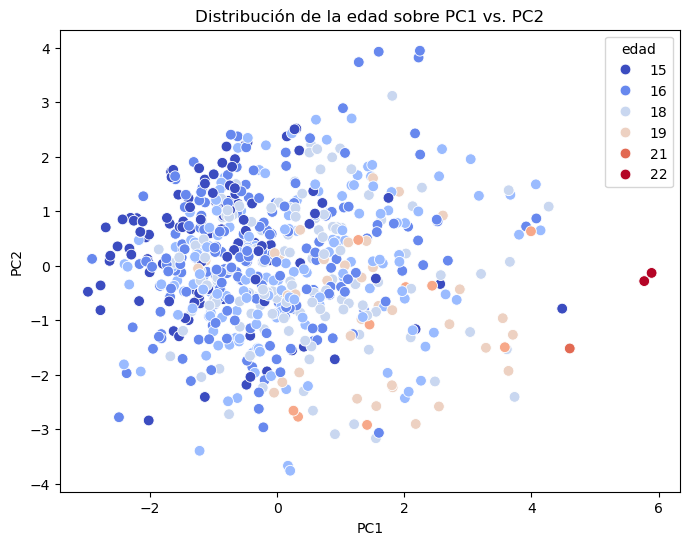

In [110]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=pc_df, x="PC1", y="PC2", hue="edad", palette="coolwarm", s=60)
plt.title("Distribución de la edad sobre PC1 vs. PC2")
plt.show()

In [111]:
# suponiendo que tu pipeline es Pipeline([("prep", preproc), ("pca", pca_k)])
prep   = pipe_k.named_steps["prep"]           # ColumnTransformer
pca_k  = pipe_k.named_steps["pca"]            # PCA(n_components=k)


num_names = num_vars

# 1.b. nombres de las categóricas tras one-hot
cat_encoder = prep.named_transformers_["cat"] # OneHotEncoder
cat_names   = cat_encoder.get_feature_names_out(cat_vars)

# 1.c. concatenar
feature_names = np.concatenate([num_names, cat_names])

In [112]:
pc1_loadings = pipe_k["pca"].components_[0]

loadings_df = pd.DataFrame({
    "feature": feature_names,
    "loading": pc1_loadings
})

# 2.c. ordenar por magnitud absoluta del loading
loadings_df["abs_loading"] = loadings_df["loading"].abs()
loadings_df = loadings_df.sort_values("abs_loading", ascending=False)

In [113]:
# Mostrar las 10 variables con mayor contribución en PC1
top10 = loadings_df.head(10)[["feature","loading"]]
print(top10.to_string(index=False))

      feature   loading
          Alc  0.426894
    suspensos  0.380481
        SalAm  0.369882
    TiempoLib  0.344518
TiempoEstudio -0.323837
         edad  0.312793
        PMedu -0.265078
  TiempoViaje  0.246130
       faltas  0.172567
       sexo_M  0.091808


In [114]:
model = LinearRegression()
model.fit(Z_train, y_train)

y_pred = model.predict(Z_test)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"RMSE (PCA): {rmse:.3f}")
print(f"MAE  (PCA): {mae:.3f}")
print(f"R²   (PCA): {r2:.3f}")

RMSE (PCA): 3.408
MAE  (PCA): 2.517
R²   (PCA): 0.303


---
### Creación de `predicciones_finales.csv`